In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange

In [2]:
def prior(q: np.ndarray) -> float:
    return 0.5 * np.dot(q, q)

In [3]:
def grad_prior(q: np.ndarray) -> np.ndarray:
    return np.array([1, *q])

In [4]:
def model(x: np.ndarray, q: np.ndarray) -> float:
    """Linear regression model
        
        Args:
            q : model params
            x : input point
    """
    return np.dot(x, q)

In [5]:
def V(q: np.ndarray, x: np.ndarray, t: np.ndarray) -> float:
    return 0.5*np.dot(q, q) + np.sum(model(x,q)-t)
    

In [6]:
def grad_V(q: np.ndarray, x: np.ndarray, t: np.ndarray) -> np.ndarray:
    return q + np.einsum("i,ij->j", model(x,q)-t, x)
    

In [7]:
def hmc(
    V: float,
    grad_V: np.ndarray,
    eps: float,
    L: int,
    current_q: np.ndarray,
    x: np.ndarray,
    t: np.ndarray,
) -> np.ndarray:
    """Performs one step of Hamiltonian Monte Carlo

    Args:
        V (function)        :   Potential energy as a function of params q
        grad_V (function)   :   Gradient of potential energy
        eps                 :   Step size in Leapfrog method
        L                   :   Number of Leapfrog iterations
        current_q           :   Generalized coordinate (or parameter).
    """

    q = np.copy(current_q)
    q = current_q
    p = np.random.normal(0, 1, size=q.shape)
    current_p = np.copy(p)
    # Make a half step for momentum at the beginning:
    p = p - 0.5 * eps * grad_V(q, x, t)

    # Do the inner steps of Leapfrog
    for i in range(L - 1):
        q += eps * p
        p -= eps * grad_V(q, x, t)

    # Final step of Leapfrog
    q += eps * p
    p -= 0.5 * eps * grad_V(q, x, t)
    p = -p

    current_V = V(current_q, x, t)
    current_K = 0.5 * np.dot(current_p, current_p)
    proposed_V = V(q, x, t)
    proposed_K = 0.5 * np.dot(p, p)

    dV = proposed_V - current_V
    dK = proposed_K - current_K

    if np.random.uniform() >= min(1, np.exp(-dV) * np.exp(-dK)):
        current_q[:] = q[:]
    return current_q

In [8]:
def ground_truth(x) -> np.ndarray:
    w = np.array([-2, -1])
    return np.einsum("ij,j", x, w)

In [9]:
x = np.random.uniform(0, 1, size=(100, 2))

In [10]:
t = ground_truth(x)

In [11]:
q = np.random.normal(0,0.001,size=2)

In [12]:
grad_V(q, x, t)

array([90.56941838, 82.29215584])

In [13]:
N = 100000
predictions = []
for k in range(N):
    q = hmc(V, grad_V, eps=0.01, L=20, x=x, t=t, current_q=q)
    y = model(x, q)
    predictions.append(y)

In [14]:
print(predictions[0].shape)
predictions = np.array(predictions)

(100,)


In [15]:
print(predictions.shape)

(100000, 100)


In [16]:
predictions_mean = np.mean(predictions,axis=0)

In [17]:
print(predictions_mean.shape)

(100,)


(100,)
(100,)


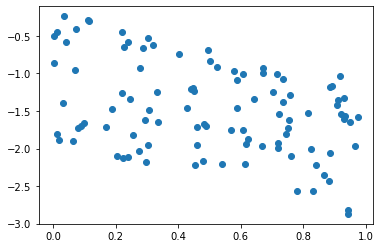

In [18]:
plt.scatter(x[:, 1], predictions_mean)
print(x[:, 1].shape)
print(predictions_mean.shape)
plt.show()